In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark as ps
import scipy.stats as stats
import sys
sys.path.append("..")
from src.support_functions import get_covid_data, fixing_datetime, get_zip_income

plt.style.use('ggplot')


In [2]:
data_by_zip, tests_by_day, tests_by_boro = get_covid_data()

In [3]:
data_by_zip = data_by_zip.rename(columns={"MODIFIED_ZCTA": "Zip",
                            "NEIGHBORHOOD_NAME": "Neighborhood",
                            "BOROUGH_GROUP": "Borough",
                            "COVID_CASE_COUNT": "Covid_Case_Count",
                            "COVID_CASE_RATE": "Covid_Case_Rate",
                            "POP_DENOMINATOR": "Pop_Denominator",
                            "COVID_DEATH_COUNT": "Covid_Death_Count",
                            "COVID_DEATH_RATE":"Covid_Death_Rate",
                            "PERCENT_POSITIVE":"Percent_Positive",
                            "TOTAL_COVID_TESTS": "Total_Covid_Tests"})

In [4]:
tests_by_day = tests_by_day.rename(columns={"DATE": "Date",
                             "TOTAL_TESTS": "Total_Tests",
                             "POSITIVE_TESTS": "Positive_Tests",
                             "PERCENT_POSITIVE": "Percent_Positive",
                             "TOTAL_TESTS_7DAYS_AVG": "Total_Tests_7Days_AVG",
                             "POSITIVE_TESTS_7DAYS_AVG": "Positive_Tests_7Days_AVG",
                             "PERCENT_POSITIVE_7DAYS_AVG": "Percent_Positive_7Days_AVG",
                             "INCOMPLETE": "Incomplete"})

In [5]:
tests_by_boro = tests_by_boro.rename(columns={"BOROUGH_GROUP": "Borough",
                             "CASE_RATE": "Case_Rate",
                             "HOSPITALIZED_RATE": "Hospitalized_Rate",
                             "DEATH_RATE": "Death_Rate",
                             "CASE_COUNT": "Case_Count",
                             "HOSPITALIZED_COUNT": "Hospitalized_Count",
                             "DEATH_COUNT": "Death_Count"})

In [6]:
median_income = get_zip_income()
med_income = median_income['median_income']
data_by_zip = data_by_zip.join(med_income)

In [7]:
tests_by_day = fixing_datetime(tests_by_day)

In [8]:
turnstile2019_df = pd.read_csv('../data/Turnstile_Usage_Data__2019.csv', low_memory=False)
turnstile2020_df = pd.read_csv('../data/Turnstile_Usage_Data__2020.csv', low_memory=False)

In [9]:
ts_df_2019 = fixing_datetime(turnstile2019_df)
ts_df_2020 = fixing_datetime(turnstile2020_df)

In [28]:
gb2019 = ts_df_2019[['Unit', 'SCP', 'Date', 'Entries']].groupby(['Date', 'Unit', 'SCP']).agg([min, max])
gb2019.reset_index()

gb2019['Total'] = gb2019[('Entries', 'max')] - gb2019[('Entries', 'min')]
gb2019.drop(gb2019[gb2019['Total'] < 1000].index, inplace=True)
gb2019.drop(gb2019[gb2019['Total'] > 10000].index, inplace=True)

sum_per_station_2019 = gb2019.groupby(level=[0, 1]).sum()

sum_per_date_2019 = sum_per_station_2019.groupby(level=[0]).sum()

sum_per_date_2019['week_avg_2019'] = sum_per_date_2019.iloc[:,2].rolling(window=7).mean()

In [29]:
gb2020 = ts_df_2020[['Unit', 'SCP', 'Date', 'Entries']].groupby(['Date', 'Unit', 'SCP']).agg([min, max])
gb2020.reset_index()

gb2020['Total'] = gb2020[('Entries', 'max')] - gb2020[('Entries', 'min')]
gb2020.drop(gb2020[gb2020['Total'] < 1000].index, inplace=True)
gb2020.drop(gb2020[gb2020['Total'] > 10000].index, inplace=True)

sum_per_station_2020 = gb2020.groupby(level=[0, 1]).sum()

sum_per_date_2020 = sum_per_station_2020.groupby(level=[0]).sum()

sum_per_date_2020['week_avg_2020'] = sum_per_date_2020.iloc[:,2].rolling(window=7).mean()

## Hypothesis Test

H0: 

(array([ 4.,  0.,  6.,  7., 12.,  3.,  2.,  1.,  5.,  3.,  2.,  9.,  6.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  3.,  1.,  5.,  4.,  8.,
         6.,  6.,  6., 12., 13., 13.,  9., 21., 12.,  8.,  6.]),
 array([ 581114.  ,  668125.14,  755136.28,  842147.42,  929158.56,
        1016169.7 , 1103180.84, 1190191.98, 1277203.12, 1364214.26,
        1451225.4 , 1538236.54, 1625247.68, 1712258.82, 1799269.96,
        1886281.1 , 1973292.24, 2060303.38, 2147314.52, 2234325.66,
        2321336.8 , 2408347.94, 2495359.08, 2582370.22, 2669381.36,
        2756392.5 , 2843403.64, 2930414.78, 3017425.92, 3104437.06,
        3191448.2 , 3278459.34, 3365470.48, 3452481.62, 3539492.76,
        3626503.9 , 3713515.04, 3800526.18, 3887537.32, 3974548.46,
        4061559.6 , 4148570.74, 4235581.88, 4322593.02, 4409604.16,
        4496615.3 , 4583626.44, 4670637.58, 4757648.72, 4844659.86,
        4931671.  ]),
 <a list of 50

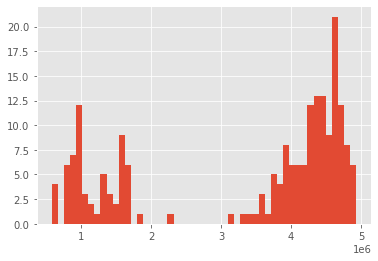

In [14]:
plt.hist(sum_per_date_2019['Total'], bins=50)

In [15]:
sum_per_date_2019['Total'].describe()

count    1.990000e+02
mean     3.366365e+06
std      1.512992e+06
min      5.811140e+05
25%      1.583899e+06
50%      4.160894e+06
75%      4.562820e+06
max      4.931671e+06
Name: Total, dtype: float64

In [17]:
sum_per_date_2020['Total'].describe()

count    1.620000e+02
mean     3.077568e+05
std      8.918797e+05
min      1.002000e+03
25%      5.697500e+03
50%      5.258200e+04
75%      1.255848e+05
max      4.400154e+06
Name: Total, dtype: float64

In [18]:
norm_approx = stats.norm(sum_per_date_2019['Total'].mean(), sum_per_date_2019['Total'].std() )

TypeError: float() argument must be a string or a number, not 'rv_frozen'

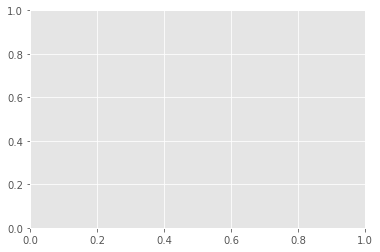

In [27]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 200, num=1)
#axs[1].plot(x, normal_approx.pdf(x), linewidth=3)
ax.plot(x, norm_approx)

In [25]:
len(sum_per_date_2019['Total'])

199